In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cross_validation, metrics
import tensorflow as tf

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# run environment

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.4)
sess_config = tf.ConfigProto(gpu_options=gpu_options)

# label

In [3]:
labels = {'0':'file', '1':'network', '2':'service', '3':'database', '4':'communication', '5':'memory', '6':'driver', 
    '7':'system', '8':'application', '9':'io', '10':'others', '11':'security', '12':'disk', '13':'processor'}

fault_label = {'0':'file', '1':'network', '2':'service', '3':'database', '4':'communication', '5':'memory', '6':'driver', 
    '7':'system','9':'io', '10':'others', '11':'security', '12':'disk', '13':'processor'}

# load data

In [4]:
def one_hot(y):
    y = y.reshape(len(y))
    n_values = np.max(y) + 1
    return np.eye(n_values)[np.array(y, dtype=np.int32)]  # Returns FLOATS


def load_X(X_path):
    X_list = []
    file = open(X_path, 'r')
    # Read dataset from disk, dealing with text files' syntax
    X_signal = [np.array(item, dtype=np.float32) for item in [
               line.strip().split('\t') for line in file]]
    X_list.append(X_signal)
    file.close()
    return np.transpose(np.array(X_list), (1, 2, 0))


# Load "y" (the neural network's training and testing outputs)
def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array([elem for elem in [line.strip().split('\t') for line in file]], 
                  dtype=np.int32)
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    return one_hot(y_-1)


dataset_path = "../data_msg_type/"
trainX_path = dataset_path + "semantic_train_x.txt"
trainY_path = dataset_path + "semantic_train_y.txt"
testX_path = dataset_path + "semantic_test_x.txt"
testY_path = dataset_path + "semantic_test_y.txt"


train_x = load_X(trainX_path)
train_y = load_y(trainY_path)
test_x = load_X(testX_path)
test_y = load_y(testY_path)

train_x = train_x.reshape(len(train_x), 10, 14, 1)
test_x = test_x.reshape(len(test_x), 10, 14, 1)

'''
# Separate our training data into test and training.
print("Separating data into 80% training set & 20% test set...")
train_x, test_x, train_y, test_y = cross_validation.train_test_split(
    x, y, test_size=0.2, random_state=33)#add random state here...
'''

print("Dataset separated.\n")
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

Dataset separated.

((80000, 10, 14, 1), (80000, 14), (20000, 10, 14, 1), (20000, 14))


# define parameters

In [5]:
learning_rate = 0.0001
training_iters = 16000000
batch_size = 1000
display_step = 20000

# Network Parameters
input_height = 10
input_width = 14
num_channels = 1
n_classes = 14
dropout = 0.75 # Dropout, probability to keep units

# network config

In [6]:
# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')


# Create model
def conv_net(x, weights, biases, dropout):
    # Reshape input picture
    x = tf.reshape(x, shape=[-1, 10, 14, 1])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)
    print(conv1.shape)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)
    print(conv2.shape)
    
    # Convolution Layer
    conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
    conv4 = conv2d(conv3, weights['wc4'], biases['bc4'])
    conv5 = conv2d(conv4, weights['wc5'], biases['bc5'])
    # Max Pooling (down-sampling)
    conv5 = maxpool2d(conv5, k=2)
    print(conv3.shape)
    print(conv4.shape)
    print(conv5.shape)

    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv5, [-1, weights['wd1'].get_shape().as_list()[0]])
    
    # Fully connected layer
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, dropout)
    print(fc1.shape)
    fc2 = tf.add(tf.matmul(fc1, weights['wd2']), biases['bd2'])
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, dropout)
    print(fc2.shape)

    # Output, class prediction
    fc3 = tf.add(tf.matmul(fc2, weights['out']), biases['out'])
    print(fc3.shape)
    return fc3

# Store layers weight & bias
weights = {
    # 3x4 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([3, 4, 1, 32])),
    # 3x4 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([3, 4, 32, 64])),
    # 3x4 conv, 64 inputs, 64 outputs
    'wc3': tf.Variable(tf.random_normal([3, 4, 64, 64])),
    # 3x4 conv, 64 inputs, 32 outputs
    'wc4': tf.Variable(tf.random_normal([3, 4, 64, 32])),
    # 3x4 conv, 32 inputs, 64 outputs
    'wc5': tf.Variable(tf.random_normal([3, 4, 32, 64])),
    # fully connected, 2*2*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([2*2*64, 1024])),
    # fully connected, 1024 inputs, 512 outputs
    'wd2': tf.Variable(tf.random_normal([1024, 512])),
    # 512 inputs, 14outputs (class prediction)
    'out': tf.Variable(tf.random_normal([512, n_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bc3': tf.Variable(tf.random_normal([64])),
    'bc4': tf.Variable(tf.random_normal([32])),
    'bc5': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'bd2': tf.Variable(tf.random_normal([512])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# build model

In [7]:
x = tf.placeholder(tf.float32, [None,input_height,input_width,num_channels])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

pred = conv_net(x, weights, biases, keep_prob)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

(?, 5, 7, 32)
(?, 3, 4, 64)
(?, 3, 4, 64)
(?, 3, 4, 32)
(?, 2, 2, 64)
(?, 1024)
(?, 512)
(?, 14)


# train and test

In [8]:
def extract_batch_size(_train, step, batch_size):   
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data.    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)
    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 
    return batch_s


test_losses = []
test_accuracies = []
test_predictions = []
train_losses = []
train_accuracies = []


init = tf.global_variables_initializer()
with tf.Session(config=sess_config) as sess:
    sess.run(init)
    
    step = 1
    # Keep training until reach max iterations
    while step * batch_size <= training_iters:
        batch_xs = extract_batch_size(train_x, step, batch_size)
        batch_ys = extract_batch_size(train_y, step, batch_size)

        # Fit training using batch data
        _, loss, acc = sess.run([optimizer, cost, accuracy],
                       feed_dict={x: batch_xs, y: batch_ys, keep_prob: dropout})

        train_losses.append(loss)
        train_accuracies.append(acc)  
        
        
        batch_xt = extract_batch_size(test_x, step, batch_size)
        batch_yt = extract_batch_size(test_y, step, batch_size)
    
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        test_predict, test_loss, test_acc = sess.run([pred, cost, accuracy], 
                                            feed_dict={x: batch_xt, y: batch_yt, keep_prob: 1.})
        
        test_predictions.append(np.argmax(test_predict, axis=1))
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        # Evaluate network only at some steps for faster training: 
        if (step*batch_size % display_step == 0) or (step == 1) \
            or (step * batch_size > training_iters):

            print("Training epochs #" + str(step*batch_size) + \
                  ": Batch Loss = " + "{:.6f}".format(loss) + \
                  ", Accuracy = {}".format(acc))
        
            print("Performance on test set: " + "Training epochs #" + str(step*batch_size) +\
                  ", Batch Loss = {}".format(test_loss) + ", Accuracy = {}".format(test_acc))
        step += 1

    print("Optimization Finished!")

Training epochs #1000: Batch Loss = 874367104.000000, Accuracy = 0.0540000014007
Performance on test set: Training epochs #1000, Batch Loss = 391158944.0, Accuracy = 0.00900000054389
Training epochs #20000: Batch Loss = 477987872.000000, Accuracy = 0.0939999967813
Performance on test set: Training epochs #20000, Batch Loss = 104416624.0, Accuracy = 0.0140000013635
Training epochs #40000: Batch Loss = 191959264.000000, Accuracy = 0.283000022173
Performance on test set: Training epochs #40000, Batch Loss = 20726914.0, Accuracy = 0.805000066757
Training epochs #60000: Batch Loss = 104805752.000000, Accuracy = 0.573000013828
Performance on test set: Training epochs #60000, Batch Loss = 49491400.0, Accuracy = 0.805000066757
Training epochs #80000: Batch Loss = 79962584.000000, Accuracy = 0.692000031471
Performance on test set: Training epochs #80000, Batch Loss = 52158720.0, Accuracy = 0.805000066757
Training epochs #100000: Batch Loss = 443740832.000000, Accuracy = 0.0569999963045
Performa

Training epochs #920000: Batch Loss = 12187474.000000, Accuracy = 0.733999967575
Performance on test set: Training epochs #920000, Batch Loss = 1674983.125, Accuracy = 0.949000000954
Training epochs #940000: Batch Loss = 8817915.000000, Accuracy = 0.828000068665
Performance on test set: Training epochs #940000, Batch Loss = 2680941.75, Accuracy = 0.943000018597
Training epochs #960000: Batch Loss = 6928452.000000, Accuracy = 0.879999995232
Performance on test set: Training epochs #960000, Batch Loss = 3383669.25, Accuracy = 0.943000078201
Training epochs #980000: Batch Loss = 70995000.000000, Accuracy = 0.256999999285
Performance on test set: Training epochs #980000, Batch Loss = 1176521.25, Accuracy = 0.949000000954
Training epochs #1000000: Batch Loss = 12951668.000000, Accuracy = 0.729000031948
Performance on test set: Training epochs #1000000, Batch Loss = 1538928.125, Accuracy = 0.949000120163
Training epochs #1020000: Batch Loss = 8725491.000000, Accuracy = 0.838000059128
Perform

Training epochs #1820000: Batch Loss = 4140910.250000, Accuracy = 0.902000069618
Performance on test set: Training epochs #1820000, Batch Loss = 1494650.25, Accuracy = 0.961000025272
Training epochs #1840000: Batch Loss = 2451909.250000, Accuracy = 0.929000020027
Performance on test set: Training epochs #1840000, Batch Loss = 1540370.25, Accuracy = 0.961000025272
Training epochs #1860000: Batch Loss = 30092770.000000, Accuracy = 0.391000002623
Performance on test set: Training epochs #1860000, Batch Loss = 463645.625, Accuracy = 0.982000112534
Training epochs #1880000: Batch Loss = 4743455.000000, Accuracy = 0.842000007629
Performance on test set: Training epochs #1880000, Batch Loss = 1020000.5625, Accuracy = 0.961000025272
Training epochs #1900000: Batch Loss = 3547544.250000, Accuracy = 0.896000027657
Performance on test set: Training epochs #1900000, Batch Loss = 1389720.0, Accuracy = 0.961000025272
Training epochs #1920000: Batch Loss = 1986203.250000, Accuracy = 0.921000003815
Pe

Training epochs #2720000: Batch Loss = 1058347.750000, Accuracy = 0.93700003624
Performance on test set: Training epochs #2720000, Batch Loss = 621419.25, Accuracy = 0.960999965668
Training epochs #2740000: Batch Loss = 14461748.000000, Accuracy = 0.472000002861
Performance on test set: Training epochs #2740000, Batch Loss = 320504.90625, Accuracy = 0.991000056267
Training epochs #2760000: Batch Loss = 1630406.375000, Accuracy = 0.906000077724
Performance on test set: Training epochs #2760000, Batch Loss = 346320.125, Accuracy = 0.976000070572
Training epochs #2780000: Batch Loss = 1837928.500000, Accuracy = 0.925000011921
Performance on test set: Training epochs #2780000, Batch Loss = 633309.1875, Accuracy = 0.961000025272
Training epochs #2800000: Batch Loss = 879272.437500, Accuracy = 0.952000021935
Performance on test set: Training epochs #2800000, Batch Loss = 573557.125, Accuracy = 0.975000023842
Training epochs #2820000: Batch Loss = 15040706.000000, Accuracy = 0.525999963284
Pe

Training epochs #3620000: Batch Loss = 7900935.000000, Accuracy = 0.598999977112
Performance on test set: Training epochs #3620000, Batch Loss = 220006.140625, Accuracy = 0.991000056267
Training epochs #3640000: Batch Loss = 766393.000000, Accuracy = 0.943000078201
Performance on test set: Training epochs #3640000, Batch Loss = 201612.25, Accuracy = 0.982000052929
Training epochs #3660000: Batch Loss = 845048.937500, Accuracy = 0.960000097752
Performance on test set: Training epochs #3660000, Batch Loss = 319235.75, Accuracy = 0.975000083447
Training epochs #3680000: Batch Loss = 453962.000000, Accuracy = 0.967000007629
Performance on test set: Training epochs #3680000, Batch Loss = 279982.5, Accuracy = 0.975000023842
Training epochs #3700000: Batch Loss = 6736238.000000, Accuracy = 0.625999927521
Performance on test set: Training epochs #3700000, Batch Loss = 217617.0625, Accuracy = 0.991000056267
Training epochs #3720000: Batch Loss = 733270.937500, Accuracy = 0.944999992847
Performa

Training epochs #4520000: Batch Loss = 362331.375000, Accuracy = 0.958000004292
Performance on test set: Training epochs #4520000, Batch Loss = 69995.375, Accuracy = 0.990000009537
Training epochs #4540000: Batch Loss = 384027.875000, Accuracy = 0.966000020504
Performance on test set: Training epochs #4540000, Batch Loss = 118106.71875, Accuracy = 0.982000112534
Training epochs #4560000: Batch Loss = 244206.546875, Accuracy = 0.978999972343
Performance on test set: Training epochs #4560000, Batch Loss = 75631.5859375, Accuracy = 0.982000112534
Training epochs #4580000: Batch Loss = 4547869.500000, Accuracy = 0.65600001812
Performance on test set: Training epochs #4580000, Batch Loss = 140363.375, Accuracy = 0.991000056267
Training epochs #4600000: Batch Loss = 342301.000000, Accuracy = 0.959000051022
Performance on test set: Training epochs #4600000, Batch Loss = 72819.140625, Accuracy = 0.990000009537
Training epochs #4620000: Batch Loss = 488916.093750, Accuracy = 0.962000012398
Perf

Training epochs #5420000: Batch Loss = 304412.937500, Accuracy = 0.96899998188
Performance on test set: Training epochs #5420000, Batch Loss = 21064.5625, Accuracy = 0.991000056267
Training epochs #5440000: Batch Loss = 54793.925781, Accuracy = 0.986999928951
Performance on test set: Training epochs #5440000, Batch Loss = 2237.6340332, Accuracy = 0.999000072479
Training epochs #5460000: Batch Loss = 2154863.500000, Accuracy = 0.747000038624
Performance on test set: Training epochs #5460000, Batch Loss = 68945.9765625, Accuracy = 0.991000056267
Training epochs #5480000: Batch Loss = 168840.093750, Accuracy = 0.972000062466
Performance on test set: Training epochs #5480000, Batch Loss = 6134.80566406, Accuracy = 0.991000056267
Training epochs #5500000: Batch Loss = 213733.921875, Accuracy = 0.973999977112
Performance on test set: Training epochs #5500000, Batch Loss = 17117.4589844, Accuracy = 0.991000056267
Training epochs #5520000: Batch Loss = 132178.531250, Accuracy = 0.976999998093


Training epochs #6340000: Batch Loss = 1160440.500000, Accuracy = 0.824000000954
Performance on test set: Training epochs #6340000, Batch Loss = 40854.9765625, Accuracy = 0.990999996662
Training epochs #6360000: Batch Loss = 81481.335938, Accuracy = 0.979000031948
Performance on test set: Training epochs #6360000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #6380000: Batch Loss = 199142.531250, Accuracy = 0.976999938488
Performance on test set: Training epochs #6380000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #6400000: Batch Loss = 42558.960938, Accuracy = 0.992000043392
Performance on test set: Training epochs #6400000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #6420000: Batch Loss = 859929.062500, Accuracy = 0.861000001431
Performance on test set: Training epochs #6420000, Batch Loss = 47996.4609375, Accuracy = 0.991000056267
Training epochs #6440000: Batch Loss = 79759.140625, Accuracy = 0.981000006199
Performance on test set: Train

Training epochs #7280000: Batch Loss = 26537.119141, Accuracy = 0.993000090122
Performance on test set: Training epochs #7280000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #7300000: Batch Loss = 619908.062500, Accuracy = 0.882000029087
Performance on test set: Training epochs #7300000, Batch Loss = 22596.0703125, Accuracy = 0.991000056267
Training epochs #7320000: Batch Loss = 40036.187500, Accuracy = 0.988999962807
Performance on test set: Training epochs #7320000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #7340000: Batch Loss = 63259.773438, Accuracy = 0.985999941826
Performance on test set: Training epochs #7340000, Batch Loss = 298.641021729, Accuracy = 0.999000072479
Training epochs #7360000: Batch Loss = 10617.785156, Accuracy = 0.996000051498
Performance on test set: Training epochs #7360000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #7380000: Batch Loss = 514727.250000, Accuracy = 0.883000016212
Performance on test set: Trainin

Training epochs #8220000: Batch Loss = 37678.410156, Accuracy = 0.990000069141
Performance on test set: Training epochs #8220000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #8240000: Batch Loss = 18133.361328, Accuracy = 0.994000077248
Performance on test set: Training epochs #8240000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #8260000: Batch Loss = 394258.125000, Accuracy = 0.887000143528
Performance on test set: Training epochs #8260000, Batch Loss = 13737.3457031, Accuracy = 0.991000056267
Training epochs #8280000: Batch Loss = 15537.091797, Accuracy = 0.989000022411
Performance on test set: Training epochs #8280000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #8300000: Batch Loss = 53252.640625, Accuracy = 0.985000014305
Performance on test set: Training epochs #8300000, Batch Loss = 0.0, Accuracy = 1.0
Training epochs #8320000: Batch Loss = 5270.896973, Accuracy = 0.996000051498
Performance on test set: Training epochs #8320000, Batc

Training epochs #9160000: Batch Loss = 17109.568359, Accuracy = 0.989000022411
Performance on test set: Training epochs #9160000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #9180000: Batch Loss = 19829.607422, Accuracy = 0.991000056267
Performance on test set: Training epochs #9180000, Batch Loss = 180.654510498, Accuracy = 0.999000072479
Training epochs #9200000: Batch Loss = 7451.831543, Accuracy = 0.997000038624
Performance on test set: Training epochs #9200000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #9220000: Batch Loss = 280421.843750, Accuracy = 0.90700006485
Performance on test set: Training epochs #9220000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #9240000: Batch Loss = 18469.869141, Accuracy = 0.992000102997
Performance on test set: Training epochs #9240000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #9260000: Batch Loss = 34020.480469, Accuracy = 0.989000082016
Performance on test set: Training epochs #9260

Training epochs #10120000: Batch Loss = 2231.421631, Accuracy = 0.996000051498
Performance on test set: Training epochs #10120000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #10140000: Batch Loss = 12247.398438, Accuracy = 0.995999932289
Performance on test set: Training epochs #10140000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #10160000: Batch Loss = 2684.555664, Accuracy = 0.998000085354
Performance on test set: Training epochs #10160000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #10180000: Batch Loss = 148478.062500, Accuracy = 0.935000061989
Performance on test set: Training epochs #10180000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #10200000: Batch Loss = 8229.369141, Accuracy = 0.996999979019
Performance on test set: Training epochs #10200000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #10220000: Batch Loss = 10558.681641, Accuracy = 0.993000030518
Performance on test set: Training epochs #10220

Training epochs #11080000: Batch Loss = 2916.617188, Accuracy = 0.996999979019
Performance on test set: Training epochs #11080000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #11100000: Batch Loss = 2193.842285, Accuracy = 0.996999979019
Performance on test set: Training epochs #11100000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #11120000: Batch Loss = 1665.708618, Accuracy = 0.999000072479
Performance on test set: Training epochs #11120000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #11140000: Batch Loss = 98450.914062, Accuracy = 0.929000139236
Performance on test set: Training epochs #11140000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #11160000: Batch Loss = 3221.610107, Accuracy = 0.995000004768
Performance on test set: Training epochs #11160000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #11180000: Batch Loss = 6679.993164, Accuracy = 0.993000030518
Performance on test set: Training epochs #11180000

Training epochs #12040000: Batch Loss = 18103.298828, Accuracy = 0.992000102997
Performance on test set: Training epochs #12040000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #12060000: Batch Loss = 4903.218750, Accuracy = 0.996000051498
Performance on test set: Training epochs #12060000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #12080000: Batch Loss = 1610.665039, Accuracy = 0.998000025749
Performance on test set: Training epochs #12080000, Batch Loss = 0.0, Accuracy = 1.0
Training epochs #12100000: Batch Loss = 53162.917969, Accuracy = 0.956000089645
Performance on test set: Training epochs #12100000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #12120000: Batch Loss = 8458.837891, Accuracy = 0.993000090122
Performance on test set: Training epochs #12120000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #12140000: Batch Loss = 107.885506, Accuracy = 0.999000072479
Performance on test set: Training epochs #12140000, Batch Lo

Training epochs #13000000: Batch Loss = 4811.287109, Accuracy = 0.995000064373
Performance on test set: Training epochs #13000000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #13020000: Batch Loss = 1597.443604, Accuracy = 0.998000144958
Performance on test set: Training epochs #13020000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #13040000: Batch Loss = 0.000000, Accuracy = 1.00000011921
Performance on test set: Training epochs #13040000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #13060000: Batch Loss = 28134.498047, Accuracy = 0.96899998188
Performance on test set: Training epochs #13060000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #13080000: Batch Loss = 934.679260, Accuracy = 0.996000051498
Performance on test set: Training epochs #13080000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #13100000: Batch Loss = 2516.836182, Accuracy = 0.998000025749
Performance on test set: Training epochs #13100000, Batc

Training epochs #13960000: Batch Loss = 975.514526, Accuracy = 0.996999979019
Performance on test set: Training epochs #13960000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #13980000: Batch Loss = 1521.002075, Accuracy = 0.998000025749
Performance on test set: Training epochs #13980000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14000000: Batch Loss = 0.000000, Accuracy = 1.00000011921
Performance on test set: Training epochs #14000000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14020000: Batch Loss = 24169.212891, Accuracy = 0.966000080109
Performance on test set: Training epochs #14020000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14040000: Batch Loss = 743.373535, Accuracy = 0.999000072479
Performance on test set: Training epochs #14040000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14060000: Batch Loss = 536.911499, Accuracy = 0.997000098228
Performance on test set: Training epochs #14060000, Batch

Training epochs #14920000: Batch Loss = 2254.961914, Accuracy = 0.999000072479
Performance on test set: Training epochs #14920000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14940000: Batch Loss = 1937.041260, Accuracy = 0.997000098228
Performance on test set: Training epochs #14940000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14960000: Batch Loss = 188.831635, Accuracy = 0.999000072479
Performance on test set: Training epochs #14960000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14980000: Batch Loss = 30525.521484, Accuracy = 0.974999964237
Performance on test set: Training epochs #14980000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #15000000: Batch Loss = 1751.788940, Accuracy = 0.995999991894
Performance on test set: Training epochs #15000000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #15020000: Batch Loss = 1679.383423, Accuracy = 0.998000025749
Performance on test set: Training epochs #15020000,

Training epochs #15880000: Batch Loss = 1467.331299, Accuracy = 0.997000098228
Performance on test set: Training epochs #15880000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #15900000: Batch Loss = 592.681641, Accuracy = 0.998000025749
Performance on test set: Training epochs #15900000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #15920000: Batch Loss = 0.000000, Accuracy = 1.00000011921
Performance on test set: Training epochs #15920000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #15940000: Batch Loss = 19563.878906, Accuracy = 0.978000044823
Performance on test set: Training epochs #15940000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #15960000: Batch Loss = 2183.352295, Accuracy = 0.996999979019
Performance on test set: Training epochs #15960000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #15980000: Batch Loss = 805.950439, Accuracy = 0.999000072479
Performance on test set: Training epochs #15980000, Batc

# performance visualization

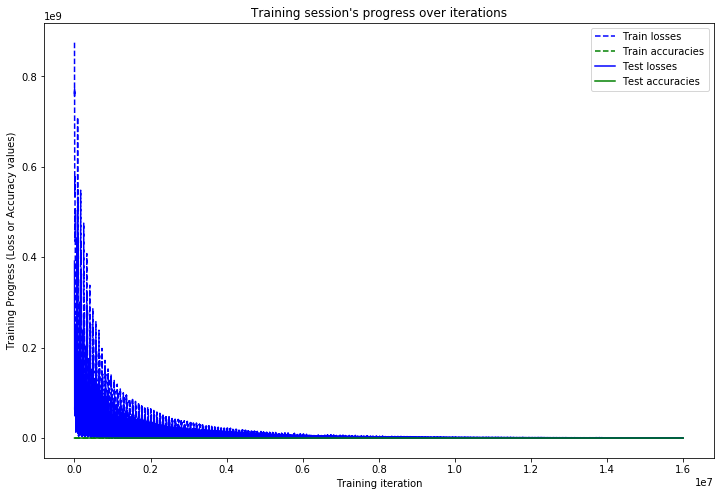

In [9]:
#font = {'family': 'Bitstream Vera Sans', 'weight': 'bold', 'size': 12}
#matplotlib.rc('font', **font)
width = 12
height = 8
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, 
                   (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_losses), "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(np.array(range(batch_size, 
                  len(test_losses)*batch_size, batch_size)), training_iters)
plt.plot(indep_test_axis, np.array(test_losses), "b-", label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=False)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training iteration')
plt.savefig('result/lstm_loss_accuracy.png')
plt.figure()
plt.show()

Best Testing Accuracy: 100.000011921%

Precision: 97.9519934706%
Recall: 97.885%
f1_score: 97.8638206703%

Confusion Matrix:
[[    5    13     0     0     0     0     0     0     0     0     0     0
      0]
 [    5   792     0     0    27    49     0    10     0     0     0    28
      0]
 [    0     0   213     0     0     0     0     0     0     0     0     0
      0]
 [    0     2     0     0     0     0     0     0     0     0     0     0
      0]
 [    0     4     0     0  2830    13     0    10     0     0     0    34
      0]
 [    7    26     0     0     0   311     0     1     0     0     0     3
      0]
 [    0     4     0     0     0     3 14486     0     0     0     0     2
      0]
 [    0    45     0     0    35    43     0   399     0     0     1    12
      0]
 [    0     0     0     0     0     0     0     0   132     0     0     0
      0]
 [    0     0     0     0     0     0     0     0     0     2     0     2
      0]
 [    0     0     0     0     0     0     0  

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


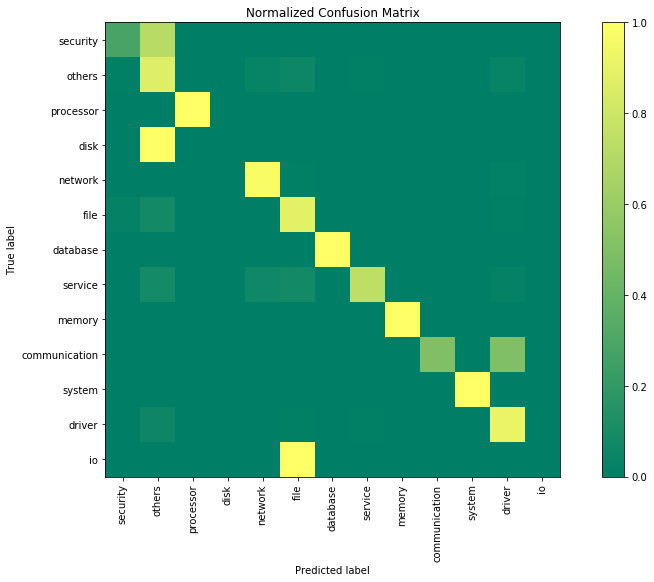

In [10]:
# Results
predictions = []
length = len(test_predictions)-20
for i in range(20):
    predictions.extend(test_predictions[length+i])

true_y = np.argmax(test_y, axis=1)

print("Best Testing Accuracy: {}%".format(100*max(test_accuracies)))

print("")
print("Precision: {}%".format(100*metrics.precision_score(
    true_y, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(true_y, 
    predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(true_y, 
    predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(true_y, predictions)
print(confusion_matrix)

# Plot: 
## cmap can be changed to many colors, (colormaps.Oranges,OrRd, etc)
def plot_CM(cm, title="Normalized Confusion Matrix", cmap=plt.cm.summer):
    width = 12
    height = 8
    plt.figure(figsize=(width, height))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(fault_label))
    plt.xticks(tick_marks, fault_label.values(), rotation=90)
    plt.yticks(tick_marks, fault_label.values())
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()
    
print(metrics.classification_report(
    true_y, predictions, target_names = list(labels.values())))

cm = confusion_matrix

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
plt.figure()
plot_CM(cm_normalized)